# Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 1
version = 1
param_num = 1

In [2]:
assert testcase == 1 and version == 1

**Idée :** On se place ici dans un des cas tests proposés : TestCase1,1_v2,2.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modfenics.solver_fem.solver_fem_1_analysecvglimit import FEMSolver
from testcases.utils import create_tree

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/u2/lecourtier/miniconda3/envs/test_phifem/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Using device: cpu


In [5]:
from testcases.networks.test_2D.test_1.test_1_v1 import Run_laplacian2D,Poisson_2D

result_dir = "../../../results/fenics/test_2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/analyse/"
create_tree(result_dir)

/home/u2/lecourtier/Article1
torch loaded; device is cpu


/home/u2/lecourtier/Article1
>> load network /home/u2/lecourtier/Article1/networks/test_2D/test_fe1.pth
network loaded
Error  tensor([0.0029])


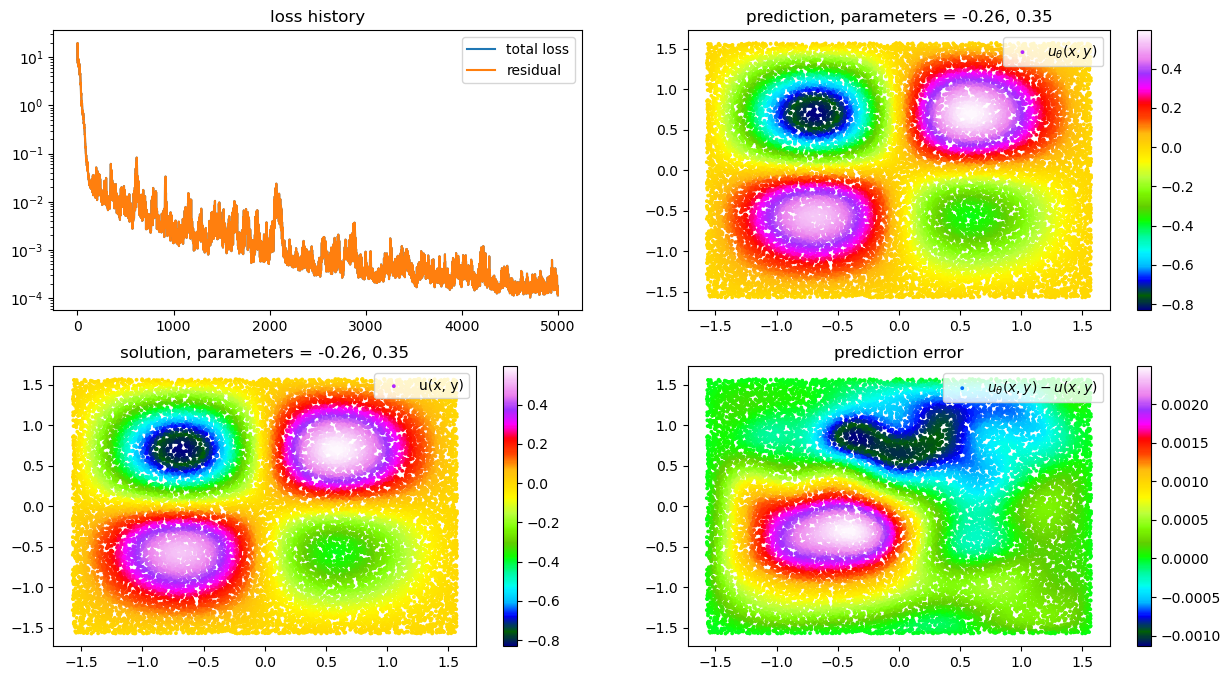

In [6]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [7]:
def get_param(i):
    params = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = [np.random.uniform(params[0][0], params[0][1]), np.random.uniform(params[1][0], params[1][1])]
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.05 0.22]


In [8]:
def compute_slope(i,tab_nb_vert,tab_err):
    start = [tab_nb_vert[i],tab_err[i]]
    end = [tab_nb_vert[i-1],tab_err[i-1]]
    third = [end[0],start[1]]

    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]
    ]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)

    slope = -(np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = slope.round(2)
    
    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    
    return slope,vert_mid

## Convergence PINNs+Corr

In [10]:
def get_test_sample(i,V_test,trainer):
    # get coordinates of the dof
    # V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return X_test,mu_test

In [12]:
def read_csv_Corr(testcase,param_num,degree,degree_PINNs):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}__degree_PINNs{degree_PINNs}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,degree_PINNs,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}__degree_PINNs{degree_PINNs}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree,degree_PINNs)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [2**i for i in range(4,9)]+[512]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
            tab_h_Corr.append(solver.h)
            
            # compute u_PINNs
            V_test = df.FunctionSpace(solver.mesh,"CG",degree_PINNs)
            X_test,mu_test = get_test_sample(0,V_test,trainer)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            
            # compute u_PINNs sur Vex
            V_test = solver.V_ex
            X_test,mu_test = get_test_sample(0,V_test,trainer)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs_Vex = df.Function(V_test)
            u_PINNs_Vex.vector()[:] = phi_tild.copy()
            
            _,_,norme_L2 = solver.corr_add(0,u_PINNs,u_PINNs_Vex)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

degree=3
## degree_PINNs :  5
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/analyse/Corr_case1_param1_degree3__degree_PINNs5.csv
[4.928677208061798e-05, 2.940023755977689e-06, 1.7571049641698794e-07, 1.0701410817693112e-08, 7.120264516084622e-10]
degree=3
## degree_PINNs :  6
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/analyse/Corr_case1_param1_degree3__degree_PINNs6.csv
[1.836184825318309e-06, 5.8275575874892455e-08, 3.1686570875277294e-09, 1.906791269512488e-10, 4.0176922739721886e-11]
degree=3
## degree_PINNs :  7
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/analyse/Corr_case1_param1_degree3__degree_PINNs7.csv
[9.667965968728077e-07, 5.3054149524420224e-08, 3.1300785572287702e-09, 1.9001698481455998e-10, 2.6610236691703178e-11, 7.627660457854131e-11]
degree=3
## degree_PINNs :  8
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/analyse/Corr_case1_param1_degree3__degree_PINNs8.csv
[9.628874929

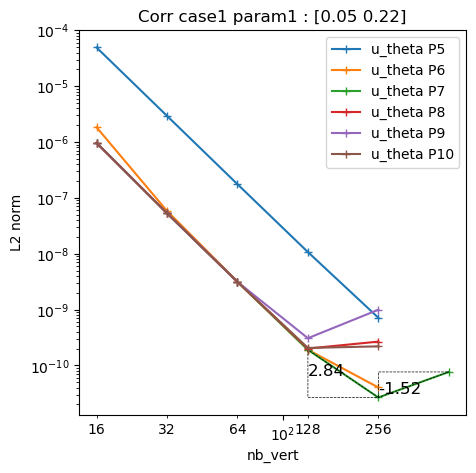

In [14]:
plt.figure(figsize=(5, 5))

# plot Corr error (L2 norm) as a function of h
d = 3
for degree_PINNs in [5,6,7,8,9,10]:
    print(f"degree={d}")
    print("## degree_PINNs : ",degree_PINNs)
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d,degree_PINNs)
    print(tab_err_Corr)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], "+-", label='u_theta P'+str(degree_PINNs))
    
    # for i in range(1,len(tab_nb_vert_Corr)):
    #     slope, vert_mid = compute_slope(i,tab_nb_vert_Corr,tab_err_Corr)
    #     plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')
    
    if degree_PINNs == 7:
        for i in range(len(tab_nb_vert_Corr)-2,len(tab_nb_vert_Corr)):
            slope, vert_mid = compute_slope(i,tab_nb_vert_Corr,tab_err_Corr)
            plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=True)
plt.xlabel("nb_vert")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')